In [256]:
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm

In [466]:
# Sample random effects
rfx1 = np.random.normal(0, 20, 30)
rfx2 = np.random.normal(0, 30, 30)
rfx3 = np.random.normal(0, 3, 40)

# Sample fixed effects
ffx = np.random.normal(0, 1, 100)

# regression
y1 = 1 + rfx1 + 2*ffx[0:30]
y2 = 1 + rfx2 + 2*ffx[30:60]
y3 = 1 + rfx3 + 2*ffx[60:]

# Logistic
y1 = 1/(1+np.exp(-y1))
y2 = 1/(1+np.exp(-y2))
y3 = 1/(1+np.exp(-y3))

# EDF Bernoulli
size = 1
probabilities = np.concatenate((y1,y2,y3), axis=0)
obs = np.random.binomial(1, probabilities[:, np.newaxis], (100, size)).flatten()


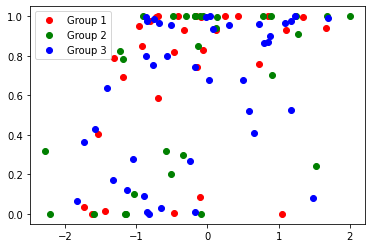

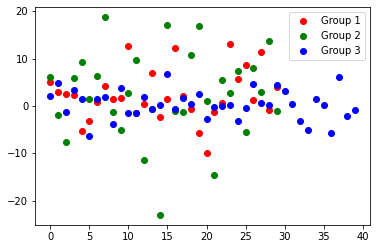

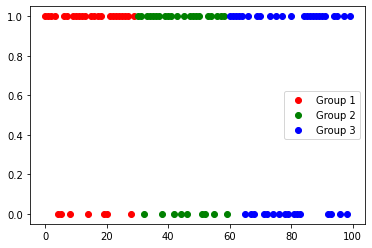

In [467]:
plt.plot(ffx[0:30],y1, 'o',color='red',label='Group 1')
plt.plot(ffx[30:60],y2, 'o',color='green',label='Group 2')
plt.plot(ffx[60:],y3, 'o',color='blue',label='Group 3')
plt.legend()
plt.show()

plt.plot(rfx1, 'o',color='red',label='Group 1')
plt.plot(rfx2, 'o',color='green',label='Group 2')
plt.plot(rfx3, 'o',color='blue',label='Group 3')
plt.legend()
plt.show()

plt.plot(range(30),obs[0:30],'o',color='red',label='Group 1')
plt.plot(range(30,60),obs[30:60],'o',color='green',label='Group 2')
plt.plot(range(60,100),obs[60:],'o',color='blue',label='Group 3')
plt.legend()
plt.show()

In [468]:
from scipy.spatial.distance import pdist

def Energy_Score(beta,observations_y,simulations_Y):

    n = len(observations_y)
    m = len(simulations_Y)
    observations_y = np.array(observations_y)
    simulations_Y = np.array(simulations_Y)

    # First part |Y-y|. Gives the L2 dist scaled by power beta. Is a vector of length n/one value per location.
    diff_Y_y = np.power(
            np.linalg.norm(
                np.tile(observations_y,(m,1)) -
                simulations_Y,
            axis=1),
        beta)

    #Second part |Y-Y'|. 2* because pdist counts only once.
    diff_Y_Y = 2 * np.power(
        pdist(simulations_Y)
    ,beta)

    Energy = 2 * np.mean(diff_Y_y) - np.sum(diff_Y_Y)/(m*(m-1))
    return Energy


Energy_Score(1,[np.random.normal(size=50)],np.random.multivariate_normal(mean=np.zeros(50),cov=np.eye(50),size=10))

9.6753288398031

In [469]:
# Inference

def eval_SR(obs,X,theta,nb_draws):

    # sample rfx
    rfx1 = np.random.normal(0, theta[2], 30)
    rfx2 = np.random.normal(0, theta[3], 30)
    rfx3 = np.random.normal(0, theta[4], 40)

    # logistic
    u1 = 1/(1+np.exp(-(theta[0]+rfx1+theta[1]*X[0:30])))
    u2 = 1/(1+np.exp(-(theta[0]+rfx2+theta[1]*X[30:60])))
    u3 = 1/(1+np.exp(-(theta[0]+rfx3+theta[1]*X[60:])))

    # sample bernoulli(u)
    y1_ = np.random.binomial(1, u1[:, np.newaxis], (30,nb_draws))
    y2_ = np.random.binomial(1, u2[:, np.newaxis], (30,nb_draws))
    y3_ = np.random.binomial(1, u3[:, np.newaxis], (40,nb_draws))
    y_ = np.concatenate((y1_,y2_,y3_), axis=0).transpose()
    # compute SR
    SR = Energy_Score(1,obs,y_)

    return SR

eval_SR(obs,ffx,[1,2,1,2,3],1000)

7.203272588692192

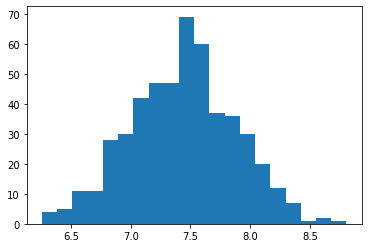

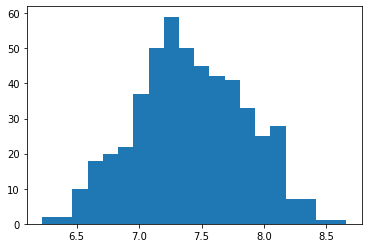

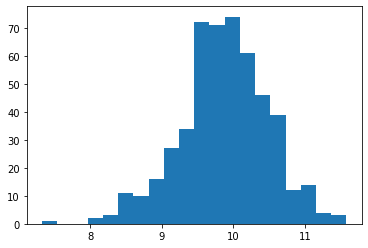

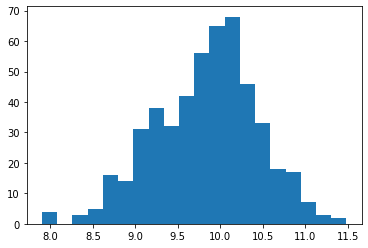

In [370]:
plt.hist([eval_SR(obs,ffx,[1,2,1,2,3],1000) for k in range(500)],bins=20)
plt.show()
plt.hist([eval_SR(obs,ffx,[1,2,1,2,3],100) for k in range(500)],bins=20)
plt.show()
plt.hist([eval_SR(obs,ffx,[10,10,10,10,10],1000) for k in range(500)],bins=20)
plt.show()
plt.hist([eval_SR(obs,ffx,[10,10,10,10,10],100) for k in range(500)],bins=20)
plt.show()

In [477]:
out = []
for B0 in tqdm(np.linspace(1,101,50)):
    k=[]
    for B1 in np.linspace(1,101,50):
        k.append(eval_SR(obs,ffx,[1,2,B0,B1,3],1000))

    out.append(k)   

100%|██████████| 50/50 [02:03<00:00,  2.46s/it]


In [427]:
print(np.where(out==np.min(out)),
np.linspace(-10,10,100)[np.where(out==np.min(out))[0]],
np.linspace(-10,10,100)[np.where(out==np.min(out))[1]])

(array([53], dtype=int64), array([57], dtype=int64)) [0.70707071] [1.51515152]


In [428]:
np.linspace(-10,10,100)[24]

-5.151515151515151

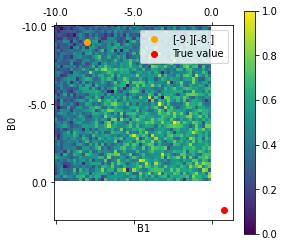

In [464]:
plt.matshow(np.array(out))
plt.xticks(np.linspace(0,100,5),np.linspace(-10,10,5))
plt.yticks(np.linspace(0,100,5),np.linspace(-10,10,5))
plt.scatter([np.where(out==np.min(out))[1]],
[np.where(out==np.min(out))[0]],color='orange',label=
str(np.round(np.linspace(-10,10,100)[np.where(out==np.min(out))[0]],1))+str(np.round(np.linspace(-10,10,100)[np.where(out==np.min(out))[1]],1)))
plt.scatter(54,59,label='True value',color='red')
plt.xlabel('B1')
plt.ylabel('B0')
plt.colorbar()
plt.legend()
plt.show()

In [480]:
np.linspace(1,101,50)[15]

31.612244897959183

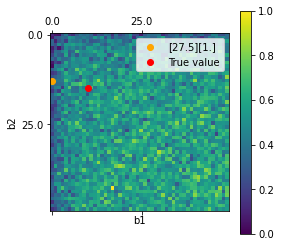

In [478]:
plt.matshow(np.array(out))
plt.xticks(np.linspace(0,100,5),np.linspace(0,100,5))
plt.yticks(np.linspace(0,100,5),np.linspace(0,100,5))
plt.scatter([np.where(out==np.min(out))[1]],
[np.where(out==np.min(out))[0]],color='orange',label=
str(np.round(np.linspace(1,101,50)[np.where(out==np.min(out))[0]],1))+str(np.round(np.linspace(1,101,50)[np.where(out==np.min(out))[1]],1)))
plt.scatter(10,15,label='True value',color='red')
plt.xlabel('b1')
plt.ylabel('b2')
plt.colorbar()
plt.legend()
plt.show()

In [438]:
# Flatten the data to a 1D array
flat_data = np.array(out).flatten()

# Get the indices of the sorted flattened array
sorted_indices = np.argsort(flat_data)

# Take the first 10 indices (corresponding to the 10 lowest values)
lowest_10_indices = sorted_indices[:20]

# Convert the 1D indices back to 2D indices (i, j)
lowest_10_2d_indices = np.unravel_index(lowest_10_indices, np.array(out).shape)

# Print the 2D indices (i, j) of the 10 lowest entries
best_ = np.array(lowest_10_2d_indices).T

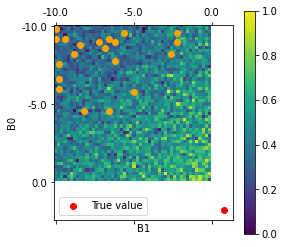

In [445]:
plt.matshow(np.array(out))
plt.xticks(np.linspace(0,100,5),np.linspace(-10,10,5))
plt.yticks(np.linspace(0,100,5),np.linspace(-10,10,5))
for b in best_:
    plt.scatter(b[1],b[0],color='orange')
plt.scatter(54,59,label='True value',color='red')
plt.legend()
plt.xlabel('B1')
plt.ylabel('B0')
plt.colorbar()
plt.show()